In [441]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import defaultdict
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from ast import literal_eval

In [47]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
oncologist_df=pickle.load(open(os.path.join(base_dir, "data/Oncologist_info_1470.pkl"),"rb"))

In [5]:
oncologist_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num
0,John H. Glick,"MD, FASCO",(215) 662-6334,University of Pennsylvania-Abramson Cancer Center,"3400 Civic Center Blvd3rd Fl, Ste 3-300S","Philadelphia, PA 19104-5127, US","[Breast Cancer, Cancer Prevention]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,7
1,Arthur M. Feldman,MD,(215) 662-9801,University of Pennsylvania-Abramson Cancer Center,Penn Presbyterian Medcl Ctr51 N 39th St MAB St...,"Philadelphia, PA 19104, US","[Breast Cancer, Geriatrics Oncology]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,0
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","[Breast Cancer, Lung Cancer, Palliative Care/E...","[Hematology, Hospice and Palliative Medicine, ...",Abramson Cancer Center,13
3,David J. Vaughn,MD,(215) 349-8140,University of Pennsylvania-Abramson Cancer Center,PCAM South 10-1143400 Civic Center Blvd,"Philadelphia, PA 19104, US","[Bladder Cancer, Prostate Cancer, Testicular C...",[Medical Oncology],Abramson Cancer Center,86
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",Pereleman Center for Advanced Medicine3400 Civ...,"Philadelphia, PA 19104, US","[Clinical Research, Developmental Therapeutics...",[Medical Oncology],Abramson Cancer Center,0


### flatten speciality

In [6]:
speciality_df=oncologist_df.copy()

In [7]:
speciality_df['combined']=oncologist_df.apply(lambda row:[(row['name'], row['speciality'],s) for s in row['speciality']],axis=1)

In [8]:
speciality_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,combined
0,John H. Glick,"MD, FASCO",(215) 662-6334,University of Pennsylvania-Abramson Cancer Center,"3400 Civic Center Blvd3rd Fl, Ste 3-300S","Philadelphia, PA 19104-5127, US","[Breast Cancer, Cancer Prevention]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,7,"[(John H. Glick, [Breast Cancer, Cancer Preven..."
1,Arthur M. Feldman,MD,(215) 662-9801,University of Pennsylvania-Abramson Cancer Center,Penn Presbyterian Medcl Ctr51 N 39th St MAB St...,"Philadelphia, PA 19104, US","[Breast Cancer, Geriatrics Oncology]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,0,"[(Arthur M. Feldman, [Breast Cancer, Geriatric..."
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","[Breast Cancer, Lung Cancer, Palliative Care/E...","[Hematology, Hospice and Palliative Medicine, ...",Abramson Cancer Center,13,"[(David M. Mintzer, [Breast Cancer, Lung Cance..."
3,David J. Vaughn,MD,(215) 349-8140,University of Pennsylvania-Abramson Cancer Center,PCAM South 10-1143400 Civic Center Blvd,"Philadelphia, PA 19104, US","[Bladder Cancer, Prostate Cancer, Testicular C...",[Medical Oncology],Abramson Cancer Center,86,"[(David J. Vaughn, [Bladder Cancer, Prostate C..."
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",Pereleman Center for Advanced Medicine3400 Civ...,"Philadelphia, PA 19104, US","[Clinical Research, Developmental Therapeutics...",[Medical Oncology],Abramson Cancer Center,0,"[(Charles John Schneider, [Clinical Research, ..."


In [9]:
speciality_flattened=[s for pair in speciality_df.combined for s in pair]
print(len(speciality_flattened))

3390


In [10]:
speciality_flattened_df=pd.DataFrame.from_records(speciality_flattened)
speciality_flattened_df.columns=['name', 'specialities','speciality']

In [11]:
speciality_flattened_df.drop(['specialities'],axis=1,inplace=True)
speciality_flattened_df.head()

,name,speciality
0,John H. Glick,Breast Cancer
1,John H. Glick,Cancer Prevention
2,Arthur M. Feldman,Breast Cancer
3,Arthur M. Feldman,Geriatrics Oncology
4,David M. Mintzer,Breast Cancer


In [12]:
pickle.dump(speciality_flattened_df, open(os.path.join(base_dir, "data/speciality_df.pkl"), "wb"))

In [45]:
speciality_flattened_df=pickle.load(open(os.path.join(base_dir, "data/speciality_df.pkl"),"rb"))

In [46]:
print('Total number of doctors with specialities: {}'.format(speciality_flattened_df.name.nunique()))

Total number of doctors with specialities: 1217


In [16]:
print('Total number of specialities: {}'.format(speciality_flattened_df.speciality.nunique()))

Total number of specialities: 79


In [17]:
speciality_array = speciality_flattened_df.speciality.unique()
print(len(speciality_array))

79


In [349]:
cancer_counts54_df=pd.read_csv(os.path.join(base_dir,'data/abstract_cancer_counts54_df.csv'),index_col='cancer_type')

In [353]:
np.setdiff1d(speciality_array, np.array(cancer_counts54_df.index))

array(['Administration', 'Advocacy',
       'BMT (Autologous/Allogeneic/Stem Cell)', 'Biologic Therapy',
       'Brain Tumors', 'Business Development',
       'Cancer Diagnosis/Staging/Prognosis', 'Cancer Education',
       'Cancer Prevention', 'Central Nervous System Tumors',
       'Chemotherapy', 'Childhood Cancers', 'Clinical Research',
       'Clinical Trials/Biostatistics/Epidemiology',
       'Complications/Morbidity', 'Consulting',
       'Developmental Therapeutics', 'Drug Development',
       'Endocrine Tumors', 'Ethics', 'Gastrointestinal Cancer',
       'Genetics/Gene Therapy', 'Geriatrics Oncology', 'Health Finance',
       'Health Services Research', 'Immunology/Immunobiology/Vaccines',
       'Infectious Diseases', 'Informatics', 'Interventional Oncology',
       'Investments', 'Laboratory Research',
       'Medical Affairs/Medical Liaisons', 'Medical Oncology/Hematology',
       'Molecular Biology', 'Neuro-Oncology', 'Nutrition', 'Obesity',
       'Oral and Oropharyngea

In [355]:
np.intersect1d(speciality_array, np.array(cancer_counts54_df.index))

array(['Anal Cancer', 'Bladder Cancer', 'Bone Cancer', 'Breast Cancer',
       'Cervical Cancer', 'Colorectal Cancer', 'Esophageal Cancer',
       'Gallbladder Cancer', 'Head and Neck Cancer', 'Kidney Cancer',
       'Leukemia', 'Liver Cancer', 'Lung Cancer', 'Lymphoma', 'Melanoma',
       'Mesothelioma', 'Multiple Myeloma', 'Ovarian Cancer',
       'Pancreatic Cancer', 'Penile Cancer', 'Prostate Cancer', 'Sarcoma',
       'Skin Cancer', 'Testicular Cancer', 'Thyroid Cancer',
       'Vaginal Cancer'], dtype=object)

### flatten pmid

In [19]:
pub_dict=pickle.load(open(os.path.join(base_dir, "data/Oncologist_info_1470_pub_dict.pkl"),"rb"))

In [20]:
puc_df = pd.DataFrame.from_dict(pub_dict, orient='index')
puc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
John H. Glick,19863338,18621616,18591552,15210738,12712466,12653603,12586796,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Arthur M. Feldman,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
David M. Mintzer,23233720,22154117,20053760,18758307,17573272,17502437,17409909,17092602,16730854,16381625,...,None,None,None,None,None,None,None,None,None,None
David J. Vaughn,29848605,29617189,29590008,29534941,29523664,29173976,28611204,28360217,28240972,28212060,...,None,None,None,None,None,None,None,None,None,None
Charles John Schneider,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [21]:
pmid_df=pd.DataFrame({'name':np.array(list(pub_dict.keys())),'pmid_list':np.array(list(pub_dict.values()))})
pmid_df.head()

,name,pmid_list
0,John H. Glick,"[19863338, 18621616, 18591552, 15210738, 12712..."
1,Arthur M. Feldman,[]
2,David M. Mintzer,"[23233720, 22154117, 20053760, 18758307, 17573..."
3,David J. Vaughn,"[29848605, 29617189, 29590008, 29534941, 29523..."
4,Charles John Schneider,[]


In [22]:
pmid_df['combined']=pmid_df.apply(lambda row:[(row['name'], row['pmid_list'],s) for s in row['pmid_list']],axis=1)

In [23]:
pmid_flattened=[p for pair in pmid_df.combined for p in pair]
print(len(pmid_flattened))

82330


In [24]:
pmid_flattened_df=pd.DataFrame.from_records(pmid_flattened)
pmid_flattened_df.columns=['name', 'pmids','pmid']

In [25]:
pmid_flattened_df.drop(['pmids'],axis=1,inplace=True)
pmid_flattened_df.head()

,name,pmid
0,John H. Glick,19863338
1,John H. Glick,18621616
2,John H. Glick,18591552
3,John H. Glick,15210738
4,John H. Glick,12712466


In [26]:
print('Number of doctors with publications: {}'.format(len(pmid_flattened_df.name.unique())))

Number of doctors with publications: 1153


In [27]:
doctor_list = pmid_flattened_df.name.unique()

In [28]:
pickle.dump(pmid_flattened_df, open(os.path.join(base_dir, "data/pmid_df2.pkl"), "wb"))

In [30]:
pmid_flattened_df=pickle.load(open(os.path.join(base_dir, "data/pmid_df2.pkl"),"rb"))

#### Merge oncologist and pmid data

In [31]:
pd.concat([speciality_flattened_df, pmid_flattened_df]).head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,name,pmid,speciality
0,John H. Glick,NaN,Breast Cancer
1,John H. Glick,NaN,Cancer Prevention
2,Arthur M. Feldman,NaN,Breast Cancer
3,Arthur M. Feldman,NaN,Geriatrics Oncology
4,David M. Mintzer,NaN,Breast Cancer


In [32]:
oncologist_speciality_pmid_df = speciality_flattened_df.merge(pmid_flattened_df, left_on='name',right_on='name',how='outer')
oncologist_speciality_pmid_df.head()

,name,speciality,pmid
0,John H. Glick,Breast Cancer,19863338
1,John H. Glick,Breast Cancer,18621616
2,John H. Glick,Breast Cancer,18591552
3,John H. Glick,Breast Cancer,15210738
4,John H. Glick,Breast Cancer,12712466


In [57]:
oncologist_speciality_pmid_df.shape

(213959, 3)

In [34]:
pickle.dump(oncologist_speciality_pmid_df, open(os.path.join(base_dir, "data/oncologist_speciality_pmid_df2.pkl"), "wb"))

In [56]:
oncologist_speciality_pmid_df=pickle.load(open(os.path.join(base_dir, "data/oncologist_speciality_pmid_df2.pkl"),"rb"))

In [50]:
oncologist_speciality_pmid_df.to_csv(os.path.join(base_dir, "data/oncologist_speciality_pmid_df2.csv"),index=False)

In [51]:
oncologist_speciality_pmid_df=pd.read_csv(os.path.join(base_dir, "data/oncologist_speciality_pmid_df2.csv"))

In [52]:
oncologist_speciality_pmid_df.query('speciality=="Breast Cancer"').shape

(12816, 3)

In [53]:
oncologist_speciality_pmid_df.query("speciality=='Breast Cancer'").pmid.nunique()

9820

In [41]:
oncologist_speciality_pmid_df.query("speciality=='Breast Cancer'").name.nunique()

275

In [58]:
oncologist_speciality_pmid_df.head()

,name,speciality,pmid
0,John H. Glick,Breast Cancer,19863338
1,John H. Glick,Breast Cancer,18621616
2,John H. Glick,Breast Cancer,18591552
3,John H. Glick,Breast Cancer,15210738
4,John H. Glick,Breast Cancer,12712466


In [116]:
def get_pmid_for_doctor(doctor,data=oncologist_speciality_pmid_df):
    pmid_array = data.query('name=="{}"'.format(doctor)).pmid.unique()
    pmid_array[~pd.isnull(pmid_array)]
    result = [int(i) for i in pmid_array]
    return np.array(result)

In [117]:
def get_pmid_for_speciality(speciality,data=oncologist_speciality_pmid_df):
    pmid_array = data.query('speciality=="{}"'.format(speciality)).pmid.unique()
    pmid_array[~pd.isnull(pmid_array)]
    result = [int(i) for i in pmid_array]
    return np.array(result)

In [362]:
abstract_catalog=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_df_50930.csv'),index_col='pmid')

In [95]:
def get_pmid_for_cancertype(cancer_type,data=abstract_catalog):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df=data[data[cancer_type]==1]
    return np.array(subset_df.index)

In [118]:
cancer_type='Breast Cancer'
a = get_pmid_for_cancertype(cancer_type,data=abstract_catalog)

### get pmid list for each cancertype -- cancer2pmid_dict

In [369]:
## get_pmid_for_cancertype for top 29 cancertypes
def get_pmid_for_cancertype(cancer_type,data=abstract_catalog):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df=data[data[cancer_type]==1]
    return list(np.array(subset_df.index))

In [370]:
cancertype_df=pd.read_csv(os.path.join(base_dir,'data/abstract_cancer_counts55_df.csv'),index_col='cancer_type')
cancer_types=np.array(cancertype_df.index)

In [371]:
cancer2pmid_dict=dict()

In [372]:
for cancer_type in cancer_types[:29]:
    cancer2pmid_dict[cancer_type]=get_pmid_for_cancertype(cancer_type)

In [373]:
## get_pmid_for_cancertype for rare cancertypes
for cancer_type in cancer_types[29:]:
    pmid_temp = cancertype_flattened_df.query('cancer_type=="{}"'.format(cancer_type)).pmid.unique()
    cancer2pmid_dict[cancer_type]=list(pmid_temp)

In [374]:
len(cancer2pmid_dict)

55

In [375]:
pickle.dump(cancer2pmid_dict, open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"), "wb"))

In [376]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [377]:
len(cancer2pmid_dict['Breast Cancer'])

8563

### get doctor list for each cancertype -- cancer2doctor_dict

In [378]:
## get_doctor_for_cancertype for top 28 cancertypes
def get_doctor_for_cancertype(cancer_type):
    cancer_pmid=get_pmid_for_cancertype(cancer_type,data=abstract_catalog)
    doctor_list=[]
    for pmid in cancer_pmid:
        doctor_list+=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(pmid)).name.unique())
    return list(set(doctor_list))

In [379]:
cancertype_df=pd.read_csv(os.path.join(base_dir,'data/abstract_cancer_counts55_df.csv'),index_col='cancer_type')
cancer_types=np.array(cancertype_df.index)

In [380]:
cancer2doctor_dict=dict()

In [381]:
for cancer_type in cancer_types[:29]:
    cancer2doctor_dict[cancer_type]=get_doctor_for_cancertype(cancer_type)

In [382]:
cancertype_flattened_df=pickle.load(open(os.path.join(base_dir, "data/cancertype_df2.pkl"),"rb"))

In [383]:
## get_doctor_for_cancertype for rare cancertypes
for cancer_type in cancer_types[29:]:
    pmid_temp = cancertype_flattened_df.query('cancer_type=="{}"'.format(cancer_type)).pmid.unique()
    doctor_list = []
    for pmid in pmid_temp:
        doctor_list+=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(pmid)).name.unique())
    cancer2doctor_dict[cancer_type]=list(set(doctor_list))  

In [387]:
len(cancer2doctor_dict)

55

In [385]:
pickle.dump(cancer2doctor_dict, open(os.path.join(base_dir, "data/cancer2doctor_dict.pkl"), "wb"))

In [386]:
cancer2doctor_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2doctor_dict.pkl"),"rb"))

In [388]:
cancer2doctor_dict_counts=[len(cancer2doctor_dict[i]) for i in cancer2doctor_dict]

In [389]:
print(max(cancer2doctor_dict_counts))
print(min(cancer2doctor_dict_counts))

799
21


In [390]:
cancer2doctor_counts_df=pd.DataFrame({'cancer_type':list(cancer2doctor_dict.keys()), 'counts':cancer2doctor_dict_counts})
cancer2doctor_counts_df.head()

,cancer_type,counts
0,Breast Cancer,799
1,Lung Cancer,777
2,Leukemia,537
3,Prostate Cancer,490
4,Colorectal Cancer,588


Text(0.5, 1.0, 'Number of oncologists for each cancer type')

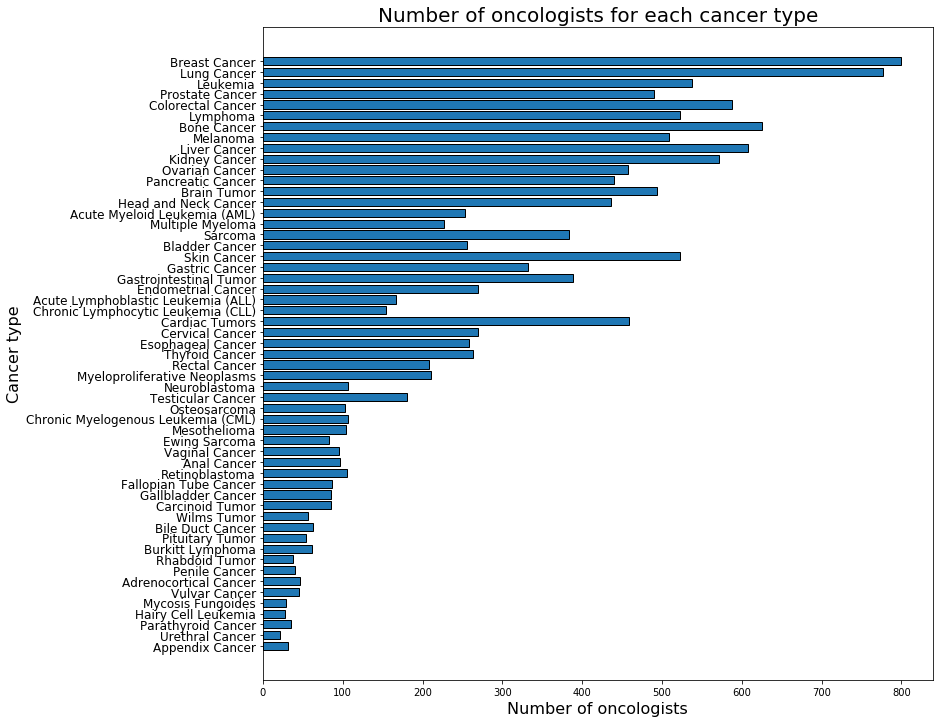

In [391]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(cancer2doctor_counts_df))  # the x locations for the groups
ax.barh(ind, cancer2doctor_counts_df.counts, width, edgecolor='black')
ax.invert_yaxis()
plt.yticks(ind, labels = cancer2doctor_counts_df.cancer_type, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,110)
plt.ylabel('Cancer type', fontsize=16)
plt.xlabel('Number of oncologists', fontsize=16)
plt.title('Number of oncologists for each cancer type', fontsize=20)

### get pmid list for each doctor -- doctor2pmid_dict

In [392]:
doctor2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2pmid_1153_dict.pkl"),"rb"))
print(len(doctor2pmid_dict))

1153


In [242]:
onco_df=pickle.load(open(os.path.join(base_dir, "data/Oncologist_info_1470.pkl"),"rb"))

In [243]:
onco_df.index=onco_df.name

In [248]:
onco_df_1153 = onco_df.loc[np.array(list(doctor2pmid_dict.keys()))]

In [299]:
article_num_df = onco_df_1153.article_num.value_counts().to_frame().reset_index().rename(columns={'article_num':'counts', 'index':'article_num'})

In [262]:
onco_df[onco_df.article_num==9815]

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num
name,,,,,,,,,,
Shaachi Gupta,Shaachi Gupta,"MBBS, MPH",(480) 256-1664,Arizona Oncology,7695S Research drive,"Tempe, AZ 85284, US",[],"[Hematology, Internal Medicine, Medical Oncology]",Arizona Cancer Center,9815


Text(0.5, 0, 'Number of articles')

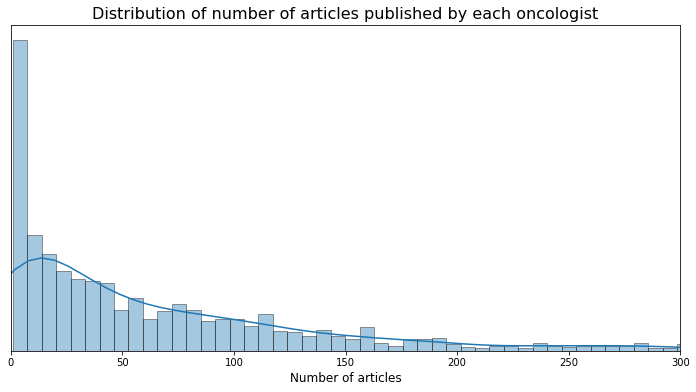

In [287]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(onco_df_1153.article_num.sort_values(ascending=False).iloc[1:].values,hist=True,bins=100,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_xlim(0,300)
ax.set_title('Distribution of number of articles published by each oncologist',fontsize=16)
ax.set_yticks([])
ax.set_xlabel('Number of articles',fontsize=12)

### get doctor for pmid -- pmid2doctor_dict

In [183]:
pmid2doctor_dict = defaultdict(list)

In [184]:
oncologist_speciality_pmid_df=pickle.load(open(os.path.join(base_dir, "data/oncologist_speciality_pmid_df2.pkl"),"rb"))

In [196]:
for pmid in abstract_catalog.index:
    pmid2doctor_dict[pmid]=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(str(pmid))).name.unique())

In [197]:
print(len(pmid2doctor_dict))

50930


In [198]:
pickle.dump(pmid2doctor_dict, open(os.path.join(base_dir, "data/pmid2doctor_dict.pkl"), "wb"))

In [199]:
pmid2doctor_dict=pickle.load(open(os.path.join(base_dir, "data/pmid2doctor_dict.pkl"),"rb"))

In [445]:
pmid2doctor_dict_df = pd.DataFrame.from_dict(pmid2doctor_dict,orient='index')
pmid2doctor_dict_df['doctor'] = pmid2doctor_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
pmid2doctor_dict_df = pmid2doctor_dict_df.loc[:,'doctor'].to_frame()
pmid2doctor_dict_df.head()

,doctor
10079468,[Hagop M. Kantarjian]
10581602,[Kenneth J. Pienta]
11719088,[James L. Abbruzzese]
11719506,[David Walterhouse]
11719516,[Karen E. Knudsen]


In [446]:
pmid2doctor_dict_df.to_csv(os.path.join(base_dir, 'data/pmid2doctor_dict_df.csv'),index=True,index_label='pmid')

In [447]:
pmid2doctor_dict_df=pd.read_csv(os.path.join(base_dir, 'data/pmid2doctor_dict_df.csv'),converters={"doctor":literal_eval})

In [448]:
pmid2doctor_dict_df.head()

,pmid,doctor
0,10079468,[Hagop M. Kantarjian]
1,10581602,[Kenneth J. Pienta]
2,11719088,[James L. Abbruzzese]
3,11719506,[David Walterhouse]
4,11719516,[Karen E. Knudsen]


In [201]:
pmid2doctor_dict_counts=[len(pmid2doctor_dict[i]) for i in pmid2doctor_dict]

In [214]:
pmid2doctor_counts_df = pd.DataFrame.from_dict(Counter(pmid2doctor_dict_counts), orient='index').rename(columns={0:'counts'})
pmid2doctor_counts_df.head()

,counts
1,36913
2,8671
3,3132
4,1286
6,210


Text(0.5, 1.0, 'Number of oncologists for each abstract')

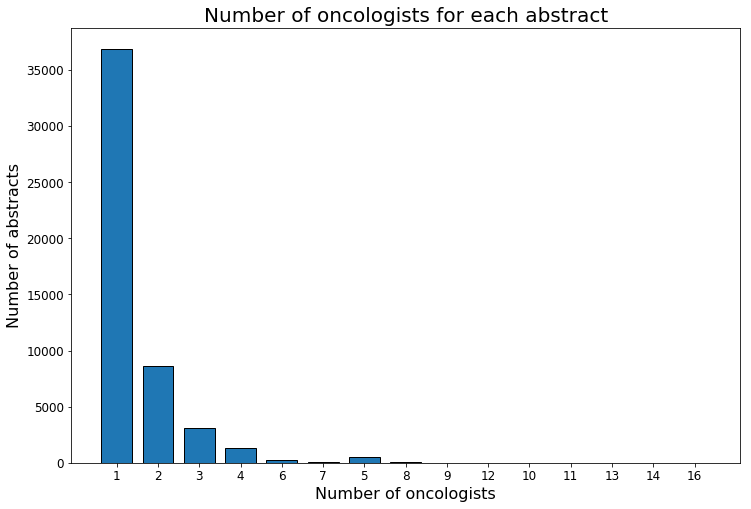

In [294]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(pmid2doctor_dict_counter))  # the x locations for the groups
ax.bar(ind, pmid2doctor_counts_df.counts, width, edgecolor='black')
plt.xticks(ind, labels = pmid2doctor_counts_df.index, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,110)]
plt.xlabel('Number of oncologists', fontsize=16)
plt.ylabel('Number of abstracts', fontsize=16)
plt.title('Number of oncologists for each abstract', fontsize=20)

Text(0.5, 0, 'Number of oncologists')

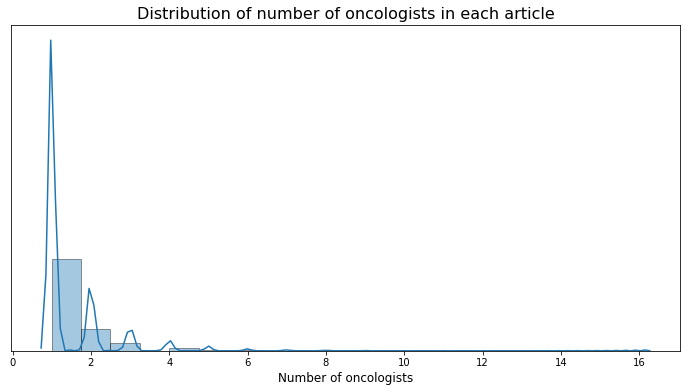

In [298]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(pmid2doctor_dict_counts,hist=True,bins=20,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_title('Distribution of number of oncologists in each article',fontsize=16)
ax.set_yticks([])
ax.set_xlabel('Number of oncologists',fontsize=12)

In [428]:
for i,v in doctor2pmid_dict.items():
    print(v)

['19863338', '18621616', '18591552', '15210738', '12712466', '12653603', '12586796']
['23233720', '22154117', '20053760', '18758307', '17573272', '17502437', '17409909', '17092602', '16730854', '16381625', '16098243', '15169988', '12714895']
['29848605', '29617189', '29590008', '29534941', '29523664', '29173976', '28611204', '28360217', '28240972', '28212060', '28039263', '27354478', '27083130', '27055371', '26639198', '26633733', '26197187', '26033814', '25544153', '25522918', '25417786', '25389114', '25332248', '24991838', '24943593', '24798985', '24764283', '24496803', '24339028', '24249435', '24008901', '23732730', '23417696', '23388561', '23206856', '23102438', '22917984', '22878886', '22658217', '22543204', '22491052', '21570610', '21551455', '21447663', '21403662', '21172112', '21166506', '20530278', '20231682', '19840017', '19731578', '19536904', '19483682', '19330334', '19164198', '19025973', '18338810', '18279928', '18279108', '18262363', '17577017', '17538159', '17484922', '

### get cancer for pmid -- pmid2cancer_dict

In [393]:
len(cancer2pmid_dict)

55

In [394]:
pmid2cancer_dict=dict()

In [395]:
for doctor in abstract_catalog.index:
    pmid2doctor_dict[pmid]=list(oncologist_speciality_pmid_df.query('pmid=="{}"'.format(str(pmid))).name.unique())

In [399]:
len(pmid2cancer_dict)

50930

In [397]:
pickle.dump(pmid2cancer_dict, open(os.path.join(base_dir, "data/pmid2cancer_dict.pkl"), "wb"))

In [449]:
pmid2cancer_dict=pickle.load(open(os.path.join(base_dir, "data/pmid2cancer_dict.pkl"),"rb"))

### get cancer for doctor -- doctor2cancer_dict

In [400]:
doctor2cancer_dict=defaultdict(list)

In [401]:
for cancer in cancer2doctor_dict:
    for doctor in cancer2doctor_dict[cancer]:
        doctor2cancer_dict[doctor].append(cancer)

In [402]:
len(doctor2cancer_dict)

1129

In [403]:
pickle.dump(doctor2cancer_dict, open(os.path.join(base_dir, "data/doctor2cancer_dict.pkl"), "wb"))

In [404]:
doctor2cancer_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2cancer_dict.pkl"),"rb"))

In [438]:
doctor2cancer_dict_df = pd.DataFrame.from_dict(doctor2cancer_dict,orient='index')
doctor2cancer_dict_df['cancer_type'] = doctor2cancer_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
doctor2cancer_dict_df = doctor2cancer_dict_df.loc[:,'cancer_type'].to_frame()
doctor2cancer_dict_df.head()

,cancer_type
Andrea Silber,"[Breast Cancer, Cardiac Tumors, Vaginal Cancer]"
Celyne Bueno-Hume,[Breast Cancer]
Kathleen N. Moore,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
Hossein Borghaei,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
Eddy J. Chen,"[Breast Cancer, Prostate Cancer]"


In [439]:
doctor2cancer_dict_df.to_csv(os.path.join(base_dir, 'data/doctor2cancer_dict_df.csv'),index=True,index_label='name')

In [442]:
doctor2cancer_dict_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2cancer_dict_df.csv'),converters={"cancer_type":literal_eval})

In [443]:
doctor2cancer_dict_df.head()

,name,cancer_type
0,Andrea Silber,"[Breast Cancer, Cardiac Tumors, Vaginal Cancer]"
1,Celyne Bueno-Hume,[Breast Cancer]
2,Kathleen N. Moore,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
3,Hossein Borghaei,"[Breast Cancer, Lung Cancer, Leukemia, Colorec..."
4,Eddy J. Chen,"[Breast Cancer, Prostate Cancer]"


In [405]:
doctor2cancer_dict_counts=[len(doctor2cancer_dict[i]) for i in doctor2cancer_dict]

In [406]:
max(doctor2cancer_dict_counts)

52

Text(0.5, 0, 'Number of cancer types')

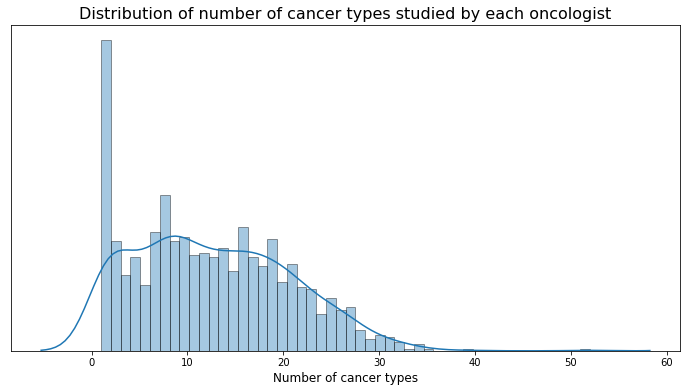

In [407]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(doctor2cancer_dict_counts,hist=True,bins=50,ax=ax,hist_kws={'edgecolor':'black'})
ax.set_title('Distribution of number of cancer types studied by each oncologist',fontsize=16)
ax.set_yticks([])
ax.set_xlabel('Number of cancer types',fontsize=12)

### get pmid for doctor -- doctor2pmid_dict

In [420]:
doctor2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/doctor2pmid_1153_dict.pkl"),"rb"))

In [422]:
len(doctor2pmid_dict)

1153

In [431]:
doctor2pmid_dict2 = dict()

In [433]:
for doctor in doctor2pmid_dict:
    doctor2pmid_dict2[doctor]=list(oncologist_speciality_pmid_df.query('name=="{}"'.format(doctor)).pmid.unique())

In [434]:
len(doctor2pmid_dict2)

1153

In [436]:
pickle.dump(doctor2pmid_dict2, open(os.path.join(base_dir, "data/doctor2pmid_1153_dict3.pkl"), "wb"))

### Extract embedded vectors for each abstract per doctor/speciality

In [61]:
abstract_embedded_df=pd.read_csv(os.path.join(base_dir,'models_w2v/doctor_recommendation_w2vmodel_dim300_mincount2.csv'),index_col='pmid')

In [62]:
print(abstract_embedded_df.shape)

(50930, 300)


#### doctor for breast cancer

In [410]:
cancer_type='Breast Cancer'
breast_onco=cancer2doctor_dict[cancer_type]

In [411]:
len(breast_onco)

799

In [412]:
breast_pmid=cancer2pmid_dict[cancer_type]

In [413]:
len(breast_pmid)

8563

In [414]:
breast_onco[:10]

['Andrea Silber',
 'Celyne Bueno-Hume',
 'Kathleen N. Moore',
 'Hossein Borghaei',
 'Eddy J. Chen',
 'Cristiane Takita',
 'Fernando Quevedo',
 'Philip C. Hoffman',
 'Sameek Roychowdhury',
 'Jeffrey A. Meyerhardt']

In [415]:
doctor2cancer_dict['Timothy Call']

['Leukemia',
 'Lymphoma',
 'Bone Cancer',
 'Melanoma',
 'Liver Cancer',
 'Kidney Cancer',
 'Acute Myeloid Leukemia (AML)',
 'Multiple Myeloma',
 'Sarcoma',
 'Skin Cancer',
 'Gastrointestinal Tumor',
 'Chronic Lymphocytic Leukemia (CLL)',
 'Cardiac Tumors',
 'Myeloproliferative Neoplasms',
 'Burkitt Lymphoma',
 'Hairy Cell Leukemia']

In [416]:
onco_df[onco_df['name']=='Timothy Call']

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num
name,,,,,,,,,,
Timothy Call,Timothy Call,MD,(507) 284-4101,Mayo Clinic,200 First St SW,"Rochester, MN 55905, US","[Physician-Patient Communication, Survivorship]","[Hematology, Internal Medicine, Medical Oncology]",Mayo Clinic Cancer Center,115


### Example: output oncologist based on cancer_type and pmid_list

In [417]:
def get_onco_info(cancer_type, pmid_list):
    """
    Input: cancer_type and a list of pmid
    Output: DataFrame containing information for oncologists that publish the articles
    """
    onco2pmid=defaultdict(list)
    for pmid in pmid_list:
        for doctor in pmid2doctor_dict[pmid]:
            onco2pmid[doctor].append(pmid)
    temp_df = onco_df.loc[np.array(list(onco2pmid.keys()))]
    temp_df['query_pmid'] = temp_df.name.apply(lambda x:onco2pmid[x])
    temp_df['query_pmid_num'] = temp_df.name.apply(lambda x:len(onco2pmid[x]))
    
    return temp_df

In [418]:
test_df = get_onco_info('Breast Cancer', breast_pmid)
test_df.shape

(799, 12)

In [419]:
test_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,query_pmid,query_pmid_num
name,,,,,,,,,,,,
Gabriel N. Hortobagyi,Gabriel N. Hortobagyi,"MD, FACP, FASCO",(713) 792-4124,University of Texas MD Anderson Cancer Center,Unit 1354PO Box 301439,"Houston, TX 77230-1439, US","[Breast Cancer, Cancer Education, Drug Develop...","[Internal Medicine, Medical Oncology]",The University of Texas MD Anderson Cancer Center,569,"[11773149, 11839684, 11844821, 11852999, 11856...",506
Kelly Hunt,Kelly Hunt,MD,Search for Phone Number,University of Texas MD Anderson Cancer Center,Dept of Surgical Oncology - Unit 444P. O. Box ...,"Houston, TX 77230-1402, US","[Breast Cancer, Sarcoma, Clinical Trials/Biost...",[Surgical Oncology],The University of Texas MD Anderson Cancer Center,469,"[11773149, 11800340, 11884322, 11923128, 11923...",347
Eddy J. Chen,Eddy J. Chen,MD,(978) 287-3436,Massachusetts General Hospital Cancer Center,55 Fruit StMgh Cancer Center,"Boston, MA 02114-2621, US","[Bladder Cancer, Kidney Cancer, Medical Oncolo...","[Hematology, Internal Medicine, Medical Oncology]",Massachusetts General Hospital,3,[11782367],1
Claudine Isaacs,Claudine Isaacs,MD,Search for Phone Number,"Lombardi Cancer Center, Georgetown University",3800 Reservoir Rd NW,"Washington, DC 20007-2113, US","[Breast Cancer, Clinical Research, Genetics/Ge...","[Internal Medicine, Medical Oncology]",Georgetown Lombardi Comprehensive Cancer Center,185,"[11786581, 11881908, 12023993, 12376518, 12464...",161
Charles L. Sawyers,Charles L. Sawyers,MD,Search for Phone Number,Memorial Sloan Kettering Cancer Center,1275 York AveBox 20,"New York, NY 10065, US",[],"[Hematology, Internal Medicine, Medical Oncology]",Memorial Sloan-Kettering Cancer Center,146,"[11790564, 11909978, 15542435, 28873162, 29057...",7


#### Get abstracts for each cancer type for each doctor -- Cancer - Doctor - Abstract

In [ ]:
temp_dict=defaultdict(list)
for cancer_type in cancer_types:
    pmid_list = cancer2pmid_dict[cancer_type]
    for pmid in pmid_list:
        doctor_list = pmid2doctor_dict[pmid]
        for doctor in doctor_list:
            temp_dict[doctor].append(pmid)

In [455]:
abstract_df=pd.read_csv(os.path.join(base_dir, "data/abstract_citation_annot_df_50930.csv"),index_col='pmid')
abstract_df.head()

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days,citation,abstract_clean,Breast Cancer,...,Endometrial Cancer,Acute Lymphoblastic Leukemia (ALL),Chronic Lymphocytic Leukemia (CLL),Cardiac Tumors,Cervical Cancer,Esophageal Cancer,Thyroid Cancer,Rectal Cancer,text_clean_seq,text_length
pmid,,,,,,,,,,,,,,,,,,,,,
2357786,Pseudohypoproteinemia and multiple myeloma.,Cleveland Clinic journal of medicine,Cleve Clin J Med,1990-05-01,Paraproteinemia is an important diagnostic fea...,Case Reports,10857.0,1.0,Paraproteinemia is an important diagnostic fea...,0,...,0,0,0,0,0,0,0,0,"[20985, 16, 35, 305, 752, 2705, 1, 232, 3, 188...",786.0
7512659,Comparison of digital rectal examination and s...,The Journal of urology,J. Urol.,1994-05-01,To compare the efficacy of digital rectal exam...,Clinical Trial,9396.0,1218.0,To compare the efficacy of digital examination...,0,...,0,0,0,0,0,0,0,1,"[6, 932, 3, 209, 1, 3271, 1385, 2, 524, 112, 4...",1803.0
7523707,Accuracy of digital rectal examination and tra...,The Journal of urology,J. Urol.,1994-11-01,Not all prostate cancers are sonographically h...,Clinical Trial,9212.0,116.0,Not all cancers are sonographically hypoechoic...,0,...,0,0,0,0,0,0,0,1,"[44, 62, 163, 32, 17591, 11380, 15, 4880, 23, ...",1581.0
7525995,Selection of optimal prostate specific antigen...,The Journal of urology,J. Urol.,1994-12-01,A prospective clinical trial of prostate cance...,Clinical Trial,9182.0,230.0,A prospective clinical trial of cancer screeni...,0,...,0,0,0,0,0,0,0,1,"[8, 482, 38, 160, 1, 12, 453, 10, 426, 28, 49,...",1543.0
7692657,Effect of patient age on early detection of pr...,Urology,Urology,1993-10-01,This study was designed to determine the effec...,Clinical Trial,9608.0,132.0,This study was designed to determine the effec...,0,...,0,0,0,0,0,0,0,1,"[26, 45, 10, 1114, 6, 223, 3, 176, 1, 89, 20, ...",1774.0


In [452]:
cancer2pmid_dict['Breast Cancer']

[11773149,
 11782367,
 11786581,
 11790564,
 11792833,
 11800340,
 11804743,
 11815954,
 11821452,
 11821453,
 11821455,
 11821456,
 11838648,
 11839684,
 11844821,
 11844822,
 11845768,
 11850835,
 11852999,
 11854177,
 11856154,
 11856157,
 11856696,
 11857316,
 11870168,
 11872286,
 11875759,
 11879565,
 11881908,
 11881914,
 11884322,
 11888875,
 11894015,
 11894018,
 11895894,
 11896107,
 11899362,
 11901151,
 11908714,
 11909978,
 11912139,
 11914909,
 11918881,
 11919237,
 11920455,
 11920777,
 11921273,
 11923128,
 11923129,
 11923132,
 11929326,
 11929341,
 11929949,
 11932912,
 11933076,
 11934346,
 11937431,
 11948493,
 11956269,
 11960379,
 11966385,
 11967901,
 11968000,
 11975969,
 11976831,
 11980673,
 11981003,
 11986185,
 11986403,
 11988246,
 11988408,
 11988838,
 11994589,
 11999950,
 12000221,
 12002342,
 12006521,
 12006523,
 12006532,
 12007222,
 12010861,
 12011912,
 12015755,
 12020395,
 12023956,
 12023992,
 12023993,
 12029434,
 12036407,
 12036413,
 12036427,

In [453]:
pmid2doctor_dict[11773149]

['Gabriel N. Hortobagyi', 'Kelly Hunt']

In [119]:
doctor="Timothy Call"
doc1_pmid = get_pmid_for_doctor(doctor,data=oncologist_speciality_pmid_df)
print(len(doc1_pmid))

115


In [120]:
cancer_type='Sarcoma'
sarcoma_pmid=get_pmid_for_cancertype(cancer_type,data=abstract_catalog)
print(len(sarcoma_pmid))

1465


In [124]:
sarcoma_df=abstract_embedded_df.loc[sarcoma_pmid]

In [125]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(sarcoma_df)
embed_df=pd.DataFrame({'pmid':sarcoma_df.index,'tsne1':embed_tsne[:,0],'tsne2':embed_tsne[:,1]})

In [126]:
doc1_pmid

array([31378229, 30575108, 30117139, 29808922, 29762141, 29674426,
       29460654, 29419435, 28940587, 28685851, 28580636, 28437873,
       28424162, 28386906, 28165464, 27960571, 27903528, 27885886,
       27861157, 27820970, 27637985, 27634202, 27570087, 26956414,
       26819053, 26730972, 26699397, 26662208, 26436615, 26422251,
       26088927, 25931291, 25772131, 25745187, 25676035, 25581025,
       25479909, 25174034, 25174025, 24738974, 24723493, 24711224,
       24286263, 24111951, 23981385, 23922059, 23911703, 23841899,
       23770605, 23493782, 23486982, 23307532, 23287625, 23146413,
       23025533, 22853816, 22760587, 22700719, 22544453, 22331952,
       22038870, 22009554, 21812536, 21765023, 21131588, 21054149,
       21048153, 20855536, 20738309, 20639881, 20578179, 20568273,
       20496995, 20463087, 20332261, 20302386, 20187101, 20166206,
       19895615, 19811329, 19751240, 19620484, 19373657, 19344414,
       19255329, 19090008, 19015397, 19008456, 18990758, 18759

In [127]:
embed_df['color']=embed_df.pmid.apply(lambda x:'red' if x in doc1_pmid else 'blue')

In [128]:
embed_df.color.value_counts()

blue    1463
red        2
Name: color, dtype: int64

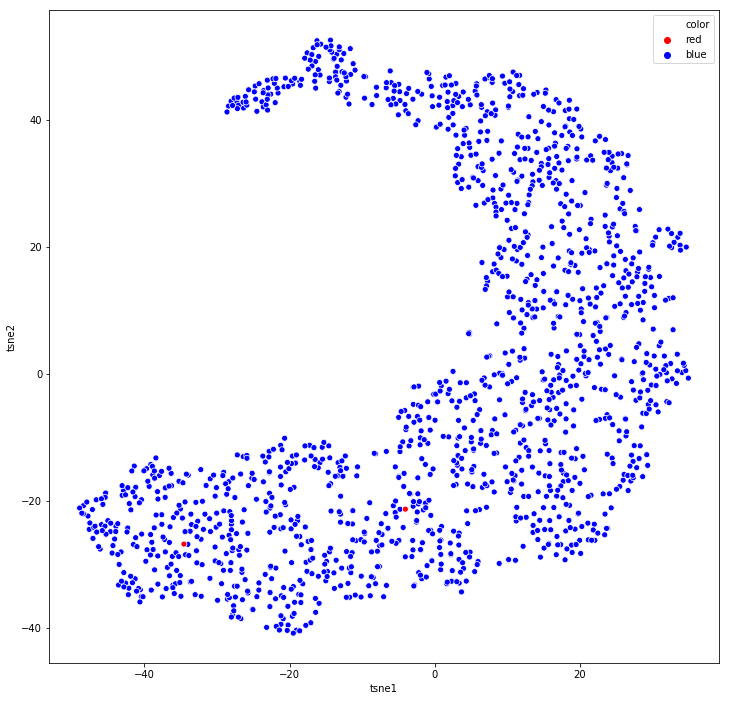

In [130]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=embed_df, hue = 'color', hue_order=['red','blue'], palette=['red','blue'], ax=ax)

#### subspeciality

In [322]:
speciality_list = speciality_flattened_df.speciality.unique()
len(speciality_list)

76

In [312]:
speciality_list

array(['Breast Cancer', 'Lung Cancer', 'Palliative Care/End of Life',
       'Head and Neck Cancer', 'Sarcoma', 'Patient Care',
       'Cancer Prevention', 'Geriatrics Oncology', 'Clinical Research',
       'Clinical Trials/Biostatistics/Epidemiology',
       'Developmental Therapeutics', 'Endocrine Tumors', 'Bladder Cancer',
       'Prostate Cancer', 'Testicular Cancer', 'Administration',
       'Medical Affairs/Medical Liaisons', 'Translational Research',
       'Tumor Biology', 'Infectious Diseases', 'Drug Development',
       'Pain & Symptom Management', 'Molecular Biology',
       'Gastrointestinal Cancer', 'Liver Cancer', 'Pancreatic Cancer',
       'Cancer Education', 'Melanoma', 'Biologic Therapy', 'Brain Tumors',
       'Immunology/Immunobiology/Vaccines', 'Other',
       'Cancer Diagnosis/Staging/Prognosis', 'Consulting',
       'Stomach Cancer', 'Genetics/Gene Therapy', 'Chemotherapy',
       'Investments', 'Psychosocial Issues/Psychiatry', 'Survivorship',
       'Physician-

In [357]:
speciality_remove=np.array(['Patient Care','Administration','Investments','Medical Affairs/Medical Liaisons','Tumor Biology','Other','Consulting','Survivorship','Physician-Patient Communication','BMT (Autologous/Allogeneic/Stem Cell)','Advocacy','Health Finance','Venture Capitalism','Practice Management','Cancer Education','Ethics','Business Development'])

In [358]:
speciality_list = np.setdiff1d(speciality_list,speciality_remove)

In [359]:
print('Total number of specialities after filtering: {}'.format(len(speciality_list)))

Total number of specialities after filtering: 59


In [360]:
speciality_embedded_dict=dict()
for speciality in speciality_list:
    temp = []
    pmid_array = get_pmid_array(doctor=None,speciality=speciality,data=oncologist_speciality_pmid_df)
    for pmid in pmid_array:
        pmid =int(pmid)
        if pmid in abstract_embedded_df.index:
            temp.append(abstract_embedded_df.loc[pmid].values)
    if temp:
        speciality_embedded_dict[speciality]=np.mean(temp,axis=0)

In [361]:
speciality_embedded_df = pd.DataFrame.from_dict(speciality_embedded_dict,orient='index')
print(speciality_embedded_df.shape)
speciality_embedded_df.head()

(58, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Anal Cancer,0.059671,-0.044412,-0.069221,-0.075363,0.031893,0.053074,-0.062766,0.049566,0.076108,0.013523,...,-0.001691,-0.022917,0.153953,-0.114621,-0.070902,-0.112668,0.143177,0.023579,0.123846,0.031859
Biologic Therapy,0.054507,-0.053431,-0.063366,-0.062916,0.029245,0.047592,-0.065769,0.049415,0.085017,0.018409,...,-0.002265,-0.018217,0.146031,-0.102272,-0.058454,-0.103178,0.136803,0.014747,0.114127,0.038217
Bladder Cancer,0.051922,-0.052171,-0.062663,-0.060738,0.029390,0.045850,-0.066040,0.049891,0.085089,0.018274,...,-0.000699,-0.020116,0.143139,-0.101503,-0.057241,-0.102630,0.136472,0.014423,0.112845,0.038131
Brain Tumors,0.053290,-0.052729,-0.062488,-0.062168,0.029345,0.046845,-0.066408,0.049423,0.085158,0.018910,...,-0.000751,-0.020360,0.144952,-0.102825,-0.058584,-0.104130,0.137390,0.014051,0.114109,0.037466
Breast Cancer,0.051138,-0.051436,-0.062327,-0.060346,0.029686,0.045156,-0.066601,0.050004,0.085617,0.018825,...,-0.000056,-0.021255,0.142792,-0.101721,-0.057260,-0.103168,0.136785,0.014018,0.112790,0.037905


In [364]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(speciality_embedded_df)
embed_df=pd.DataFrame({'speciality':speciality_embedded_df.index,'tsne1':embed_tsne[:,0],'tsne2':embed_tsne[:,1]})

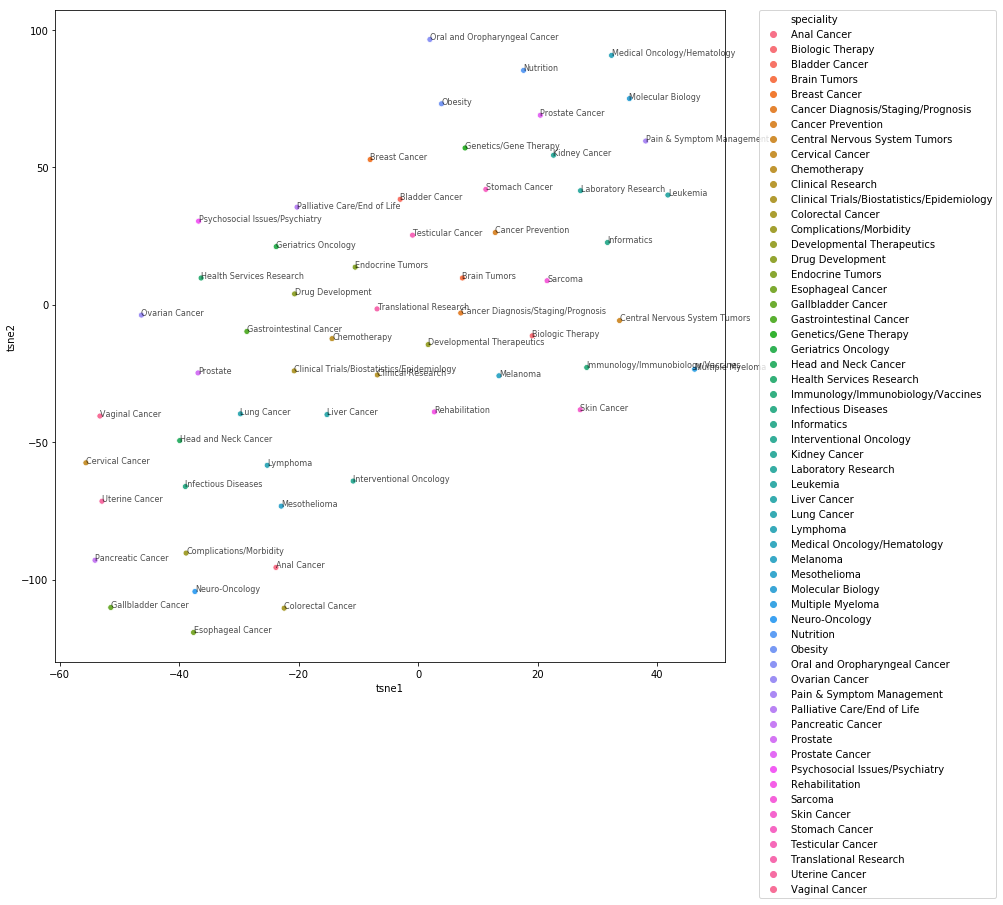

In [365]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=embed_df,hue='speciality',ax=ax)
for idx in range(len(speciality_embedded_df)):
    ax.annotate(speciality_embedded_df.index[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7,size=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [336]:
from sklearn.decomposition import PCA

In [345]:
X=speciality_embedded_df
pca = PCA(n_components=10)
embed_pca = pca.fit_transform(X)

In [347]:
print(embed_pca.shape)

(59, 10)


In [346]:
print(pca.explained_variance_ratio_)

[9.27475661e-01 5.07534103e-02 1.08147015e-02 4.88565299e-03
 3.59146545e-03 1.25390672e-03 5.20735931e-04 4.56672603e-04
 2.47718920e-04 7.44851481e-08]


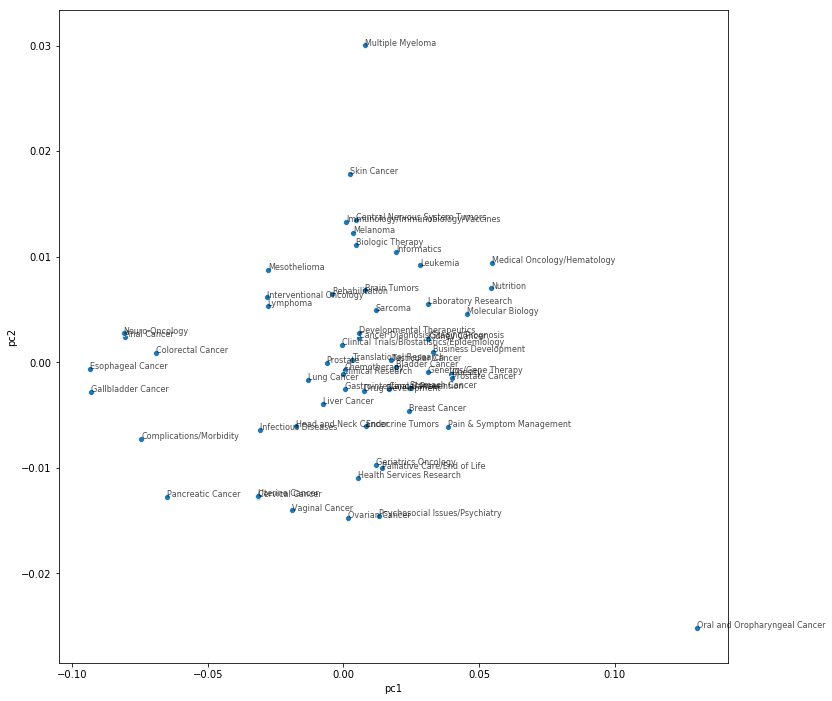

In [356]:
embed_pca_df=pd.DataFrame({'speciality':speciality_embedded_df.index,'pc1':embed_pca[:,0],'pc2':embed_pca[:,1]})
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='pc1',y='pc2',data=embed_pca_df, ax=ax)
for idx in range(len(embed_pca_df)):
    ax.annotate(embed_pca_df.speciality[idx], (embed_pca[idx, 0], embed_pca[idx, 1]), alpha=0.7,size=8)